<a href="https://colab.research.google.com/github/amarsinghen/amazon-reviews-sentiment-analysis/blob/master/amazon_reviews_sentiment_analysis_basic_model_glove_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [2]:
import zipfile
import pandas as pd
import numpy as np
import bz2
import gc
import chardet
import re
import os
import pickle
import gzip
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import seaborn as sns
import matplotlib.pyplot as plt 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Input, Conv1D, GlobalMaxPool1D, Dropout, concatenate, Layer, InputSpec, LSTM
from keras.layers import CuDNNLSTM
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers, regularizers, constraints
from tensorflow.keras.regularizers import l2
from keras.constraints import maxnorm

Using TensorFlow backend.


## Loading raw data from kaggle

In [4]:
# Downloading the data from kaggle for first time, and 
# then saving to google drive for future uses. It is faster this way
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp '/content/drive/My Drive/kaggle.json' ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d bittlingmayer/amazonreviews

 98% 482M/493M [00:08<00:00, 63.8MB/s]
100% 493M/493M [00:08<00:00, 63.6MB/s]


In [5]:
!kaggle datasets download -d naominguyen7/glovetwitter100d

 96% 383M/397M [00:06<00:00, 65.5MB/s]
100% 397M/397M [00:06<00:00, 67.4MB/s]


In [6]:
import zipfile
local_zip = ['amazonreviews.zip', 'glovetwitter100d.zip']
for i in range(len(local_zip)):
    zip_ref = zipfile.ZipFile(local_zip[i], 'r')
    zip_ref.extractall('/tmp')
    zip_ref.close()

In [7]:
train_file = bz2.BZ2File('/tmp/train.ft.txt.bz2')
test_file = bz2.BZ2File('/tmp/test.ft.txt.bz2')

In [8]:
train_file_lines = train_file.readlines()
test_file_lines = test_file.readlines()

In [9]:
print(len(train_file_lines))
print(train_file_lines[:5])
print(len(test_file_lines))
print(test_file_lines[:5])

3600000
[b'__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n', b"__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.\n", b'__label__2 Amazing

## Preprocessing Text data

In [10]:
# Convert from raw binary strings to strings that can be parsed
train_file_lines = [x.decode('utf-8') for x in train_file_lines]
test_file_lines = [x.decode('utf-8') for x in test_file_lines]

In [11]:
print(len(train_file_lines))
print(train_file_lines[:5])
print(len(test_file_lines))
print(test_file_lines[:5])

3600000
['__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n', "__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.\n", '__label__2 Amazing!: 

In [12]:
# Creating and extracting Labels
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file_lines]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file_lines]

for i in range(len(train_sentences)):
    train_sentences[i] = re.sub('\d','0',train_sentences[i])
    
test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file_lines]
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_file_lines]

for i in range(len(test_sentences)):
    test_sentences[i] = re.sub('\d','0',test_sentences[i])

# Replacing URls                                                       
for i in range(len(train_sentences)):
    if 'www.' in train_sentences[i] or 'http:' in train_sentences[i] or 'https:' in train_sentences[i] or '.com' in train_sentences[i]:
        train_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_sentences[i])
        
for i in range(len(test_sentences)):
    if 'www.' in test_sentences[i] or 'http:' in test_sentences[i] or 'https:' in test_sentences[i] or '.com' in test_sentences[i]:
        test_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", test_sentences[i])

In [13]:
print(len(train_sentences))
print(train_sentences[:5])
print(len(test_sentences))
print(test_sentences[:5])

3600000
['stuning even for the non-gamer: this sound track was beautiful! it paints the senery in your mind so well i would recomend it even to people who hate vid. game music! i have played the game chrono cross but out of all of the games i have ever played it has the best music! it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. it would impress anyone who cares to listen! ^_^', "the best soundtrack ever to anything.: i'm reading a lot of reviews saying that this is the best 'game soundtrack' and i figured that i'd write a review to disagree a bit. this in my opinino is yasunori mitsuda's ultimate masterpiece. the music is timeless and i'm been listening to it for years now and its beauty simply refuses to fade.the price tag on this is pretty staggering i must say, but if you are going to buy any cd for this much money, this is the only one that i feel would be worth every penny.", 'amazing!: this soundtrack is my favorite music 

## Tokenization

In [14]:
max_features = 20000
maxlen = 100

In [15]:
tokenizer = text.Tokenizer(num_words=max_features)

In [16]:
tokenizer.fit_on_texts(train_sentences)

In [ ]:
tokenized_train = tokenizer.texts_to_sequences(train_sentences)
X_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [ ]:
X_train[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,    74,    11,     1,
         610,  6395,     8,   176,   485,    13,   364,     6,  6071,
           1,    10,    60,   438,    27,    69,     3,    39,  1835,
           6,    74,     5,   135,    72,   678, 16703,   145,   119,
           3,    20,   524,     1,   145,  1870,    16,    40,     7,
          28,     7,     1,   597,     3,    20,   132,   524,     6,
          44,     1,    88,   119,     6,  6682,   240,    37,  5109,
           2,   422,     4, 16761,   851,    17,  8995,  3028,     2,
        4338, 19157,     6,    39,  5209,   207,    72,  2728,     5,
         336], dtype=int32)

In [17]:
tokenized_test = tokenizer.texts_to_sequences(test_sentences)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

## Using glove Embedding

In [ ]:
EMBEDDING_FILE = '/tmp/glove.twitter.27B.100d.txt'

In [ ]:
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size)) #embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


## Modeling

In [19]:
batch_size = 2048
epochs = 7
embed_size = 100

In [ ]:
def lstm_model(conv_layers = 2, max_dilation_rate = 3):
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=True)(inp)
    x = Dropout(0.25)(x)
    x = Conv1D(2*embed_size, kernel_size = 3)(x)
    prefilt = Conv1D(2*embed_size, kernel_size = 3)(x)
    x = prefilt
    for strides in [1, 1, 2]:
        x = Conv1D(128*2**(strides), strides = strides, kernel_regularizer=l2(4e-6), bias_regularizer=l2(4e-6), kernel_size=3, kernel_constraint=maxnorm(10), bias_constraint=maxnorm(10))(x)
    x_f = LSTM(512, kernel_regularizer=l2(4e-6), bias_regularizer=l2(4e-6), kernel_constraint=maxnorm(10), bias_constraint=maxnorm(10))(x)  
    x_b = LSTM(512, kernel_regularizer=l2(4e-6), bias_regularizer=l2(4e-6), kernel_constraint=maxnorm(10), bias_constraint=maxnorm(10))(x)
    x = concatenate([x_f, x_b])
    x = Dropout(0.5)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['binary_accuracy'])

    return model

lstm_model = lstm_model()
lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 100)     2000000     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 100, 100)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 98, 200)      60200       dropout_1[0][0]                  
______________________________________________________________________________________________

In [ ]:
weight_path="early_weights.hdf5"
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=5)
callbacks = [checkpoint, early_stopping]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, train_labels, test_size=0.20, shuffle = True)

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
lstm_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=callbacks, workers=4)

Epoch 1/7
1407/1407 [==============================] - ETA: 0s - loss: 0.2252 - binary_accuracy: 0.9138
Epoch 00001: val_loss improved from inf to 0.20092, saving model to early_weights.hdf5
1407/1407 [==============================] - 823s 585ms/step - loss: 0.2252 - binary_accuracy: 0.9138 - val_loss: 0.2009 - val_binary_accuracy: 0.9229
Epoch 2/7
1407/1407 [==============================] - ETA: 0s - loss: 0.1993 - binary_accuracy: 0.9254
Epoch 00002: val_loss improved from 0.20092 to 0.18133, saving model to early_weights.hdf5
1407/1407 [==============================] - 823s 585ms/step - loss: 0.1993 - binary_accuracy: 0.9254 - val_loss: 0.1813 - val_binary_accuracy: 0.9329
Epoch 3/7
1407/1407 [==============================] - ETA: 0s - loss: 0.1888 - binary_accuracy: 0.9300
Epoch 00003: val_loss improved from 0.18133 to 0.17770, saving model to early_weights.hdf5
1407/1407 [==============================] - 823s 585ms/step - loss: 0.1888 - binary_accuracy: 0.9300 - val_loss: 0.1

In [ ]:
lstm_model.load_weights(weight_path)
score, acc = lstm_model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

352/352 [==============================] - 60s 170ms/step - loss: 0.1702 - binary_accuracy: 0.9386
Test score: 0.17024697363376617
Test accuracy: 0.9386388659477234


## Predict and Evaluate using Test Data

In [20]:
testing_padded = np.array(X_test)
test_labels = np.array(test_labels)

In [21]:
saved_model_path = '/content/drive/My Drive/kaggle/amazon-reviews-sentiment-analysis/early_weights.hdf5'
loaded_model =  tf.keras.models.load_model(saved_model_path)

In [22]:
score, acc = loaded_model.evaluate(testing_padded, test_labels, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

196/196 [==============================] - 33s 170ms/step - loss: 0.1718 - binary_accuracy: 0.9382
Test score: 0.17176711559295654
Test accuracy: 0.9381775259971619


In [23]:
y_pred = loaded_model.predict(testing_padded)
print(y_pred)

[[0.9869735 ]
 [0.9972567 ]
 [0.00295759]
 ...
 [0.23328246]
 [0.9952937 ]
 [0.03605751]]


In [24]:
print("\nClassification Report : \n{}".format(classification_report(y_pred.round(), test_labels)))


Classification Report : 
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94    202601
         1.0       0.93      0.94      0.94    197399

    accuracy                           0.94    400000
   macro avg       0.94      0.94      0.94    400000
weighted avg       0.94      0.94      0.94    400000




Confusion matrix


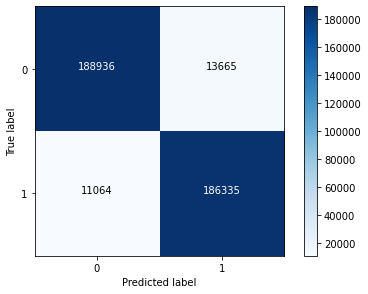

In [25]:
print("\nConfusion matrix")
conf_matrix = confusion_matrix(y_pred.round(), test_labels)
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
tick_marks = np.arange(2)   
classes = ["0","1"]
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
thresho = conf_matrix.max() / 2.
# The below for loop helps to add numbers in the boxes
for k, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, k, conf_matrix[k, j], horizontalalignment="center", color="white" if conf_matrix[k, j] > thresho else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

ROC AUC Score : 0.9381775


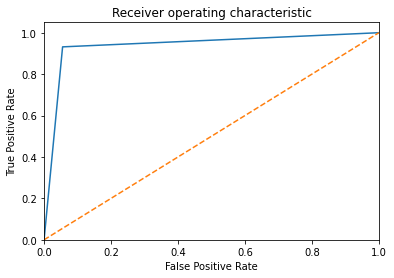

In [26]:
# Below is the ROC curve
import sklearn.metrics as m
print("ROC AUC Score : {}".format(m.roc_auc_score(test_labels, y_pred.round())))

fpr, tpr, threshold = m.roc_curve(test_labels, y_pred.round())
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()